# Notebook to compare Model Results in Tolumne UCLA vs UA 

# Step 0 - Prepare Notebook

In [1]:
import os
import time 
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from snowML.datapipe.utils import data_utils as du
from snowML.LSTM import set_hyperparams as sh
from snowML.LSTM import LSTM_pre_process as pp 
from snowML.LSTM import LSTM_train as LSTM_tr
from snowML.LSTM import LSTM_metrics as met
from snowML.LSTM import LSTM_plot3 as plot3
from snowML.Scripts import local_training_mixed_loss as ml


# Step 1 - Define HyperParams and Test Hucs 

In [2]:
# get list of hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mon = data["montane_hucs"]
print(f"Number of hcs_mon is {len(hucs_mon)}")


Number of hcs_mon is 187


In [3]:
hucs_mon[0]

'170200090208'

In [4]:
# set hyperparams
# load base line params 
params = sh.create_hyper_dict()
# reset the ones we care about
params["learning_rate"] = .001
params["n_epochs"] = 10    
params["batch_size"] = 32
params["var_list"] = ['mean_pr', 'mean_tair']
params["expirement_name"] = "UA_UCLA_Compare"
params["loss_type"] = "mse"
params["train_size_dimension"] = "time"
params["train_size_fraction"] = .67
params["recursive_rredict"] = False 
params["UCLA"] = False # start w/ UA data then update 
#params

# Step 2 - Define model functions 

In [5]:
def pre_process(huc, params): 
    # normalize the data and create train/test split 
    df_dict = pp.pre_process_separate([huc], params["var_list"], UCLA = params["UCLA"], filter_dates=params["filter_dates"])
    train_size_frac = params["train_size_fraction"]
    df = df_dict[huc]
    df_train, _, _, _ = pp.train_test_split_time(df, train_size_frac)
    return df_dict, df_train

def train_model (df_train, params): 
    model_dawgs, optimizer_dawgs, loss_fn_dawgs = ml.initialize_model(params)
   
    for epoch in range(params["n_epochs"]):
        # for local training, call fine_tune instead of pre_train
        #print(f"Training in epoch {epoch}")
        LSTM_tr.fine_tune(
            model_dawgs,
            optimizer_dawgs,
            loss_fn_dawgs,
            df_train,
            params,
            epoch
            )
    return model_dawgs 

def evaluate(model_dawgs_trained, df_dict, huc, params):
    if params["UCLA"]:
        suffix = "UCLA"
    else: 
        suffix = "UA"
    data, y_tr_pred, y_te_pred, y_tr_true, y_te_true,  y_te_pred_recur, train_size, = LSTM_tr.predict_prep (model_dawgs_trained,
                df_dict, huc, params)
    metric_dict_test = met.calc_metrics(y_te_true, y_te_pred, metric_type = f"test_{suffix}")
    if y_te_pred_recur is not None:
        metric_dict_test_recur = met.calc_metrics(y_te_true, y_te_pred_recur, metric_type = f"test_recur_{suffix}")
        combined_dict = {**metric_dict_test, **metric_dict_test_recur}
    else:
        combined_dict = metric_dict_test
        
    return combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size


def combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size, params):
    results_df = data[["mean_swe"]].copy()
    results_df["y_tr_pred"] = list(y_tr_pred) + [float('nan')] * (len(results_df) - len(y_tr_pred))
    results_df["y_te_pred"] = [float('nan')] * (train_size+params["lookback"]) + list(y_te_pred)
    results_df["y_tr_true"] = list(y_tr_true) + [float('nan')] * (len(results_df) - len(y_tr_true))
    results_df["y_te_true"] = [float('nan')] *(train_size+params["lookback"]) + list(y_te_true)
    return results_df

def label_results(df, suffix):
    df = df.add_suffix(f"_{suffix}")
    return df

def run_one_data_type (huc, params, data_type = "UA"): 
    if data_type == "UCLA": 
        params["UCLA"] = True 
        suffix = "UCLA" 
    else: 
        params["UCLA"] = False
        suffix = "UA"
    df_dict, df_train = pre_process(huc, params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # ignore warning about drop param being irrelevant with single deep layer
        model_dawgs_trained = train_model(df_train, params)
    combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size = evaluate(model_dawgs_trained, df_dict, huc, params)
    df_results = combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size, params)
    df_results = label_results(df_results, suffix)
    return combined_dict, df_results, tr_size

def run_all(hucs, params, dis = False): 
    #time_start = time.time()
    dict_UA, results_df_UA, tr_size_UA  = run_one_data_type(huc, params)
    dict_UCLA, results_df_UCLA, tr_size_UCLA = run_one_data_type (huc, params, data_type = "UCLA")
    metrics_dict_all = {**dict_UA, **dict_UCLA}
    results_df_all = pd.concat([results_df_UA, results_df_UCLA], axis=1)
    plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size_UA, huc, params, dis = dis)
    #du.elapsed(time_start)
    return metrics_dict_all, results_df_all
       

def plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size, huc, params, dis = False):
    cutoff = tr_size + params["lookback"]
    df_plot = results_df_all.iloc[cutoff:]

    # Prepare data for plots
    plot_dict_UA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UA"], "blue", "SWE Estimates UA Data (Physics Based Model)", n_offset=0)
    plot_dict_UA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UA"], "green", "SWE Predictions UA Data", n_offset=0)

    plot_dict_UCLA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UCLA"], "black", "SWE Estimates UCLA Data (Physics Based Model)", n_offset=0)
    plot_dict_UCLA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UCLA"], "red", "SWE Predictions UCLA Data", n_offset=0)

    x_axis_vals = df_plot.index
    ttl = f"SWE_Actual_vs_Predicted_for_huc_{huc}"

    # Temp file paths
    filenames = [f"plot_{i}.png" for i in range(3)]

    # Plot and save each figure
    plot3.plot3b(x_axis_vals, [plot_dict_UA_true, plot_dict_UA_pred], ttl + "_UA_data", metrics_dict=dict_UA)
    plt.savefig(filenames[0])
    plt.close()

    plot3.plot3b(x_axis_vals, [plot_dict_UCLA_true, plot_dict_UCLA_pred], ttl + "_UCLA_data", metrics_dict=dict_UCLA)
    plt.savefig(filenames[1])
    plt.close()

    plot3.plot3b(x_axis_vals,
                 [plot_dict_UA_true, plot_dict_UA_pred, plot_dict_UCLA_true, plot_dict_UCLA_pred],
                 ttl, metrics_dict=metrics_dict_all)
    plt.savefig(filenames[2])
    plt.close()

    # Combine saved plots vertically
    images = [Image.open(fname) for fname in filenames]
    widths, heights = zip(*(img.size for img in images))

    total_height = sum(heights)
    max_width = max(widths)
    combined_img = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the final combined image
    output_path = f"charts/Montane/SWE_combined_plots_{huc}.png"
    combined_img.save(output_path)
    if dis: 
        display(combined_img)
    
    # Cleanup temporary files
    for fname in filenames:
        os.remove(fname)

    print(f"Saved combined plot to {output_path}")


# Step 3 - Get Results Sample Huc 

In [6]:
huc = 170200090208

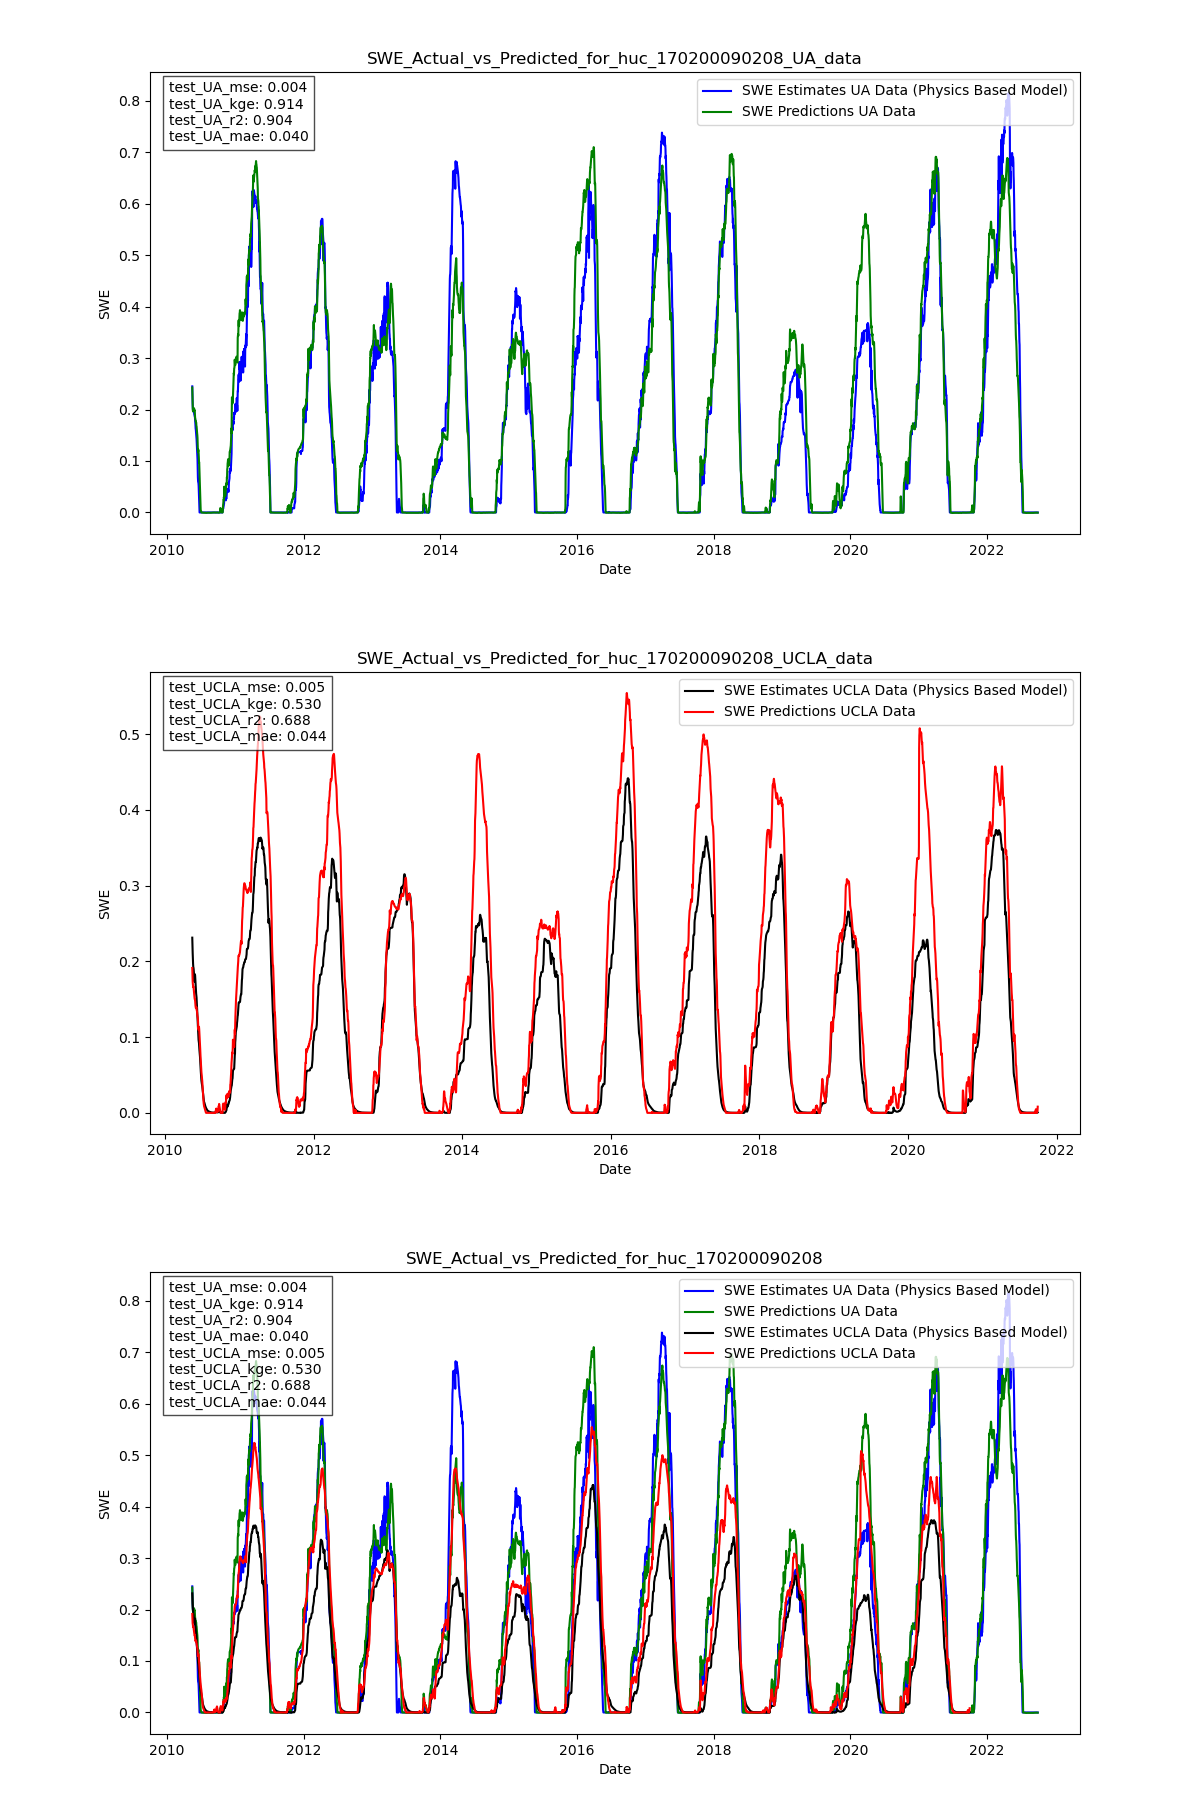

Saved combined plot to charts/Montane/SWE_combined_plots_170200090208.png


In [7]:
dict, df = run_all(huc, params, dis = True)

In [8]:
df

,mean_swe_UA,y_tr_pred_UA,y_te_pred_UA,y_tr_true_UA,y_te_true_UA,mean_swe_UCLA,y_tr_pred_UCLA,y_te_pred_UCLA,y_tr_true_UCLA,y_te_true_UCLA
day,,,,,,,,,,
1983-10-01,0.0,[0.4147155],NaN,[0.504],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-02,0.0,[0.41837066],NaN,[0.5035],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-03,0.0,[0.41911104],NaN,[0.5055],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-04,0.0,[0.41851962],NaN,[0.5005],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-05,0.0,[0.41674986],NaN,[0.5],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-25,0.0,NaN,[-0.00039887516],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2022-09-26,0.0,NaN,[-0.00046722352],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2022-09-27,0.0,NaN,[-0.000527002],NaN,[0.0],NaN,NaN,NaN,NaN,NaN


# Step 4 Loop through all the Tum

In [9]:
df_results = None
count = 0

for huc in hucs_mon:    
    count += 1
    print(f"processing huc {count}")
    dict, df = run_all(huc, params)
    f_out = f"model_results_UA_UCLA_huc_{huc}"
    b = "snowml-results"
    du.dat_to_s3(df, b, f_out, file_type="csv")
    new_row = pd.DataFrame([dict])
    new_row["huc"] = huc
    
    if df_results is None:
        df_results = new_row
    else:
        df_results = pd.concat([df_results, new_row], ignore_index=True)

df_results.set_index("huc", inplace=True)
f_out = "metrics_UA_v_UCLA_maritime"
du.dat_to_s3(df_results, b, f_out, file_type="csv")
df_results


processing huc 1
Saved combined plot to charts/Montane/SWE_combined_plots_170200090208.png
File model_results_UA_UCLA_huc_170200090208.csv successfully uploaded to snowml-results
processing huc 2
Saved combined plot to charts/Montane/SWE_combined_plots_170200090209.png
File model_results_UA_UCLA_huc_170200090209.csv successfully uploaded to snowml-results
processing huc 3
Saved combined plot to charts/Montane/SWE_combined_plots_170200090301.png
File model_results_UA_UCLA_huc_170200090301.csv successfully uploaded to snowml-results
processing huc 4
Saved combined plot to charts/Montane/SWE_combined_plots_170200090302.png
File model_results_UA_UCLA_huc_170200090302.csv successfully uploaded to snowml-results
processing huc 5
Saved combined plot to charts/Montane/SWE_combined_plots_170200090304.png
File model_results_UA_UCLA_huc_170200090304.csv successfully uploaded to snowml-results
processing huc 6
Saved combined plot to charts/Montane/SWE_combined_plots_170200110406.png
File model_res

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
huc,,,,,,,,
170200090208,0.005588,0.801716,0.874402,0.041416,0.002019,0.844651,0.860462,0.024796
170200090209,0.007027,0.781070,0.869169,0.047984,0.000783,0.889538,0.866842,0.016450
170200090301,0.003201,0.717950,0.812981,0.032940,0.001982,0.626001,0.689687,0.026932
170200090302,0.000787,0.920965,0.905447,0.017293,0.002124,0.271280,0.374982,0.028085
170200090304,0.000595,0.886940,0.841245,0.011267,0.001348,0.121735,0.005195,0.019564
...,...,...,...,...,...,...,...,...
170602080604,0.000461,0.923706,0.938190,0.013239,0.000503,0.821149,0.880972,0.015219
170602080605,0.002201,0.794334,0.894183,0.028552,0.001663,0.774208,0.894453,0.025564
170602080606,0.000680,0.661068,0.756197,0.012262,0.000385,0.897434,0.866516,0.011333


In [10]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.003203,0.840091,0.870237,0.029014,0.002861,0.704823,0.709432,0.029535
std,0.003191,0.106176,0.090244,0.014053,0.003214,0.244064,0.272170,0.016263
min,0.000130,0.410078,0.449601,0.006146,0.000194,-0.101178,-0.639292,0.005896
25%,0.001207,0.784470,0.858001,0.019631,0.000983,0.627920,0.622673,0.018973
50%,0.002279,0.873519,0.898026,0.027112,0.001950,0.786159,0.806191,0.025870
75%,0.004149,0.923310,0.921827,0.036213,0.003451,0.873533,0.887091,0.035385
max,0.023729,0.976720,0.967625,0.097847,0.020843,0.970679,0.968719,0.111065


In [11]:
df_results["kge_diff"] = df_results["test_UA_kge"] - df_results["test_UCLA_kge"]
df_results

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200090208,0.005588,0.801716,0.874402,0.041416,0.002019,0.844651,0.860462,0.024796,-0.042935
170200090209,0.007027,0.781070,0.869169,0.047984,0.000783,0.889538,0.866842,0.016450,-0.108468
170200090301,0.003201,0.717950,0.812981,0.032940,0.001982,0.626001,0.689687,0.026932,0.091949
170200090302,0.000787,0.920965,0.905447,0.017293,0.002124,0.271280,0.374982,0.028085,0.649685
170200090304,0.000595,0.886940,0.841245,0.011267,0.001348,0.121735,0.005195,0.019564,0.765205
...,...,...,...,...,...,...,...,...,...
170602080604,0.000461,0.923706,0.938190,0.013239,0.000503,0.821149,0.880972,0.015219,0.102557
170602080605,0.002201,0.794334,0.894183,0.028552,0.001663,0.774208,0.894453,0.025564,0.020125
170602080606,0.000680,0.661068,0.756197,0.012262,0.000385,0.897434,0.866516,0.011333,-0.236366


In [12]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.003203,0.840091,0.870237,0.029014,0.002861,0.704823,0.709432,0.029535,0.135268
std,0.003191,0.106176,0.090244,0.014053,0.003214,0.244064,0.272170,0.016263,0.258530
min,0.000130,0.410078,0.449601,0.006146,0.000194,-0.101178,-0.639292,0.005896,-0.447457
25%,0.001207,0.784470,0.858001,0.019631,0.000983,0.627920,0.622673,0.018973,-0.032782
50%,0.002279,0.873519,0.898026,0.027112,0.001950,0.786159,0.806191,0.025870,0.075343
75%,0.004149,0.923310,0.921827,0.036213,0.003451,0.873533,0.887091,0.035385,0.239805
max,0.023729,0.976720,0.967625,0.097847,0.020843,0.970679,0.968719,0.111065,0.988403


In [13]:
df_sorted = df_results.sort_values(by="kge_diff", ascending=False)
df_sorted

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200110603,0.000425,0.945896,0.897280,0.009948,0.000743,-0.042508,-0.014530,0.015925,0.988403
170200100205,0.001169,0.924824,0.907996,0.019694,0.002521,0.016088,0.006213,0.030693,0.908736
170300020202,0.001861,0.792200,0.897136,0.023810,0.001333,-0.083619,-0.097678,0.021881,0.875819
170103040603,0.000561,0.917200,0.898469,0.013229,0.006417,0.076334,-0.639292,0.033909,0.840867
170200100208,0.002363,0.751283,0.852389,0.027702,0.002893,-0.075931,-0.142166,0.031942,0.827214
...,...,...,...,...,...,...,...,...,...
170103020303,0.001862,0.410078,0.577438,0.026105,0.000693,0.654222,0.630021,0.015004,-0.244144
170103040602,0.004742,0.661041,0.742221,0.034122,0.001236,0.927261,0.903990,0.021071,-0.266220
170602071102,0.009160,0.575522,0.739024,0.057507,0.001494,0.854628,0.924183,0.024477,-0.279106


In [14]:
# with mlflow.start_run():
        #ml.set_ml_server(params)
        # log all the params
        #mlflow.log_params(params)
        # log the hucs & train size fraction
        #mlflow.log_param("hucs", hucs)
        # log the model
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}", pickle_module=cloudpickle)
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}")
            